In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 0. Plot setting

In [3]:
import seaborn as sb
import matplotlib

sb.set_style('whitegrid')

FONTSIZE = 10
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

# Seed Setting

In [4]:
import torch as th
import torch.nn as nn
import random

In [5]:
def set_seed(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    # os.environ["PYTHONHASHSEED"] = str(seed) # os
    th.manual_seed(seed)
    # th.cuda.manual_seed(seed)
    # th.backends.cudnn.deterministic = True
    # th.backends.cudnn.benchmark = False

# 1. Recall results

## 1. GBM

In [14]:
def geometric_brownian_motion(n_paths, maturity=30, dt=1 / 365, drift=0.0, volatility=0.2, device=None) -> th.Tensor:

    # normal_rand = th.randn(size=(maturity, n_paths))
    normal_rand = th.from_numpy(np.random.randn(maturity, n_paths)).to(th.float32)
    normal_rand[0, :] = 0.0

    noise_term = volatility * (dt ** 0.5) * normal_rand.cumsum(dim=0)   # normal_variable에 대한 cumsum이므로 variance가 dt만큼 가중돼 누적되어 나중에는 t만큼 벌어진다.
    t = th.linspace(0, maturity*dt, maturity)[:, None]    # set same device with noise_term
    return th.exp((drift - 0.5*volatility**2)*t + noise_term)


def geometric_brownian_motion2(n_paths: int, n_periods: int = 30,
                               drift: float = 0.0, volatility: float = 0.2,
                               init_price: float = 1.0, dt: float = 1/365) -> np.ndarray:

    z = np.random.standard_normal((n_periods, n_paths))
    z[0, :] = 0.0

    noise_term = volatility * np.sqrt(dt) * z.cumsum(axis=0)

    t = np.linspace(0, n_periods*dt, n_periods).reshape(-1, 1)
    # t = np.arange(0, n_periods*dt, dt).reshape(-1, 1)
    return init_price*np.exp((drift - 0.5 * volatility ** 2) * t + noise_term)

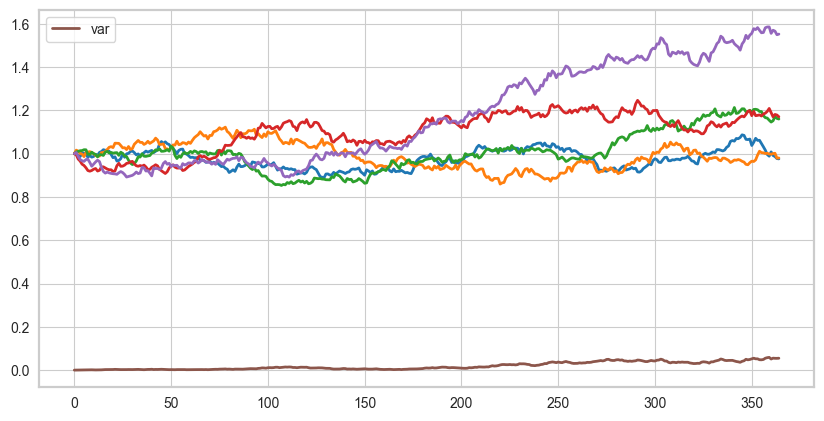

In [15]:
set_seed()
paths = geometric_brownian_motion(5, maturity=365, volatility=0.2).T
for path in paths:
    plt.plot(path)

plt.plot(th.var(paths, axis=0), label='var')
plt.legend()

## 1.2 Delta

In [8]:
# from Utils.prices import european_call_delta
from scipy.stats.distributions import norm

def european_option_delta(moneyness, expiry, volatility):
    s, t, v = map(th.as_tensor, (moneyness, expiry, volatility))
    normal = th.distributions.Normal(loc=th.tensor(0.), scale=th.tensor(1.))
    delta = normal.cdf((s.log()+(v**2/2)*t) / (v*th.sqrt(t)))
    return delta

def european_option_delta2(moneyness: np.ndarray,
                        expiry: np.ndarray,
                        volatility: float,
                        risk_free_interest: float = 0.0,
                        strike: float = 1.0, dividend: float = 0.0) -> np.ndarray:

    normal = norm(loc=0.0, scale=1.0)
    d1 = european_option_d1(moneyness, expiry, volatility, risk_free_interest)
    return normal.cdf(d1) * np.exp(-dividend * expiry)

def european_option_d1(moneyness: np.ndarray,
                       expiry: np.ndarray,
                       volatility: float,
                       risk_free_interest: float=0.0) -> np.ndarray:

    a = np.log(moneyness) + (risk_free_interest + 0.5 * volatility ** 2) * expiry
    b = volatility * np.sqrt(expiry)

    return a / b

In [34]:
moneyness = th.distributions.Normal(1., 0.2).sample((10, ))
expiry = th.full_like(moneyness, 15/365)
vol = th.full_like(moneyness, 0.2)


delta1 = european_option_delta(moneyness, expiry, vol).numpy()
delta2 = european_option_delta2(moneyness.numpy(), expiry.numpy(), vol.numpy())
# delta2 = european_option_d1(moneyness.numpy(), expiry.numpy(), vol.numpy())

np.all(delta1 - delta2 < 1e-7)

True

## 1.3 Payoff

In [9]:
def european_option_payoff(prices: th.Tensor, strike=1.0) -> th.Tensor:
    return th.nn.functional.relu(prices - strike)

def european_option_payoff2(prices: np.ndarray, strike: float = 1.0) -> np.ndarray:
    return np.clip(prices - strike, 0.0, np.inf)

In [36]:
tmp = th.randn(100)
np.all(european_option_payoff(tmp).numpy()==european_option_payoff2(tmp.numpy()))

True

## 1.4 P&L

In [21]:
def compute_pnl(model, n_assets=1000):

    prices = geometric_brownian_motion(n_assets)  # prices over all time, shape (n_steps, n_paths)

    hedge = th.zeros_like(prices[0])        # positions, shape (n_paths, )
    pnl = 0

    maturity = 30
    dt = 1/365
    vol_arg = 0.2
    transaction_cost = 1e-3

    for i in range(prices.shape[0] - 1):
        # env's observations
        moneyness = prices[i, :, None]  # obs_1, shape (n_paths, 1)
        time_expiry = th.full_like(moneyness, (maturity - i)*dt)
        volatility = th.full_like(moneyness, vol_arg)
        prev_hedge = hedge

        obs = th.cat([moneyness, time_expiry, volatility, th.unsqueeze(prev_hedge, -1)], dim=1)
        hedge = model(obs)

        # gain from price movement + loss from hedge movement
        pnl += hedge * (prices[i+1]-prices[i]) - transaction_cost * th.abs(hedge - prev_hedge) * prices[i]

    # buyer's option execution (so, it is loss for seller=(us))

    pnl -= european_option_payoff(prices[-1])

    return pnl

# from Utils.prices import geometric_brownian_motion, european_call_delta, european_option_payoff
def compute_pnl2(model, n_assets=1000):

    prices = geometric_brownian_motion(n_assets, 30, 0.0, 0.2, 1.0, 1/365)  # prices over all time, shape (n_steps, n_paths)
    hedge = np.zeros_like(prices[0])        # positions, shape (n_paths, )
    pnl = 0

    maturity = 30
    dt = 1/365
    vol_arg = 0.2
    # transaction_cost = 2e-2
    transaction_cost = 1e-3

    for i in range(prices.shape[0] - 1):
        # env's observations
        z = i
        moneyness = prices[z]  # obs_1, shape (n_paths, 1)
        time_expiry = np.full_like(moneyness, (maturity - z)*dt)
        volatility = np.full_like(moneyness, vol_arg)
        prev_hedge = hedge

        obs = th.cat([moneyness, time_expiry, volatility, th.unsqueeze(prev_hedge, -1)], dim=1)
        hedge = model(obs)


        # gain from price movement + loss from hedge movement
        gain = hedge * (prices[i+1]-prices[i]) - transaction_cost * np.abs(hedge - prev_hedge) * prices[i]
        print(np.round(hedge[:5], 4), end=" ")
        print(np.round(gain[:5], 4))
        pnl += gain

    # buyer's option execution (so, it is loss for seller=(us))

    pnl -= european_option_payoff(prices[-1])
    print(np.round(european_option_payoff(prices[-1])[:5], 4))

    return pnl, prices

## 1.5 Loss

In [16]:
def pnl_entropic_loss(pnl, aversion=1.0) -> th.Tensor:
    return -th.mean(-th.exp(-aversion*pnl), dim=-1)

def pnl_entropic_premium(pnl, aversion=1.0) -> th.Tensor:
    return -th.log(pnl_entropic_loss(pnl, aversion=aversion))

def pnl_entropic_loss2(pnl, aversion=1.0) -> th.Tensor:
    return th.mean(th.exp(-aversion*pnl), dim=-1)

# Network

In [24]:
import torch.nn.functional as F
from Utils.tensors import create_module, to_numpy, clamp

class NoTransactionBand(nn.Module):
    def __init__(self,
                 features_in,
                 net_arch, activation_fn=None, net_kwargs=None):
        super(NoTransactionBand, self).__init__()
        mlp = create_module(features_in, 2,
                            net_arch, activation_fn, net_kwargs)

        self.mlp = nn.Sequential(*mlp)

    def forward(self, obs):
        moneyness, expiry, volatility, prev_hedge = [obs[..., i] for i in range(4)]

        actions = th.tanh(self.mlp(obs))     # [-1, 1]
        delta = european_option_delta(to_numpy(moneyness),
                                    to_numpy(expiry),
                                    to_numpy(volatility))  # [0, 1]
        delta = th.tensor(delta).to(actions)

        lb = delta - F.leaky_relu(actions[..., 0])      # [-1, 1.a]
        ub = delta + F.leaky_relu(actions[..., 1])      # [-1, 1.a]

        hedge = clamp(prev_hedge, lb, ub)
        hedge = 0.5*(th.clamp(hedge, -1, 1) + 1.0)      # [0, 1]

        return hedge

    def predict(self, obs):
        return self.forward(obs), None

class NoTransactionBandNet2(nn.Module):
    def __init__(self, in_features, net_arch,
                 activation_fn = None, net_kwargs = None):
        super(NoTransactionBandNet2, self).__init__()
        self.mlp = nn.Sequential(*create_module(in_features, 2,
                                                net_arch, activation_fn, net_kwargs))

    def forward(self, obs):
        """
        :param obs: (n_paths, 3)
        :param prev_hedge: (n_paths, 1)
        """
        moneyness, expiry, volatility, prev_hedge = [obs[..., i] for i in range(4)]
        no_cost_delta = european_option_delta(moneyness, expiry, volatility)

        band_width = self.mlp(obs)
        lb = no_cost_delta - F.leaky_relu(band_width[:, 0])
        ub = no_cost_delta + F.leaky_relu(band_width[:, 1])

        hedge = clamp(prev_hedge, lb, ub)

        return hedge

# Learn

In [34]:
from tqdm import tqdm

def learn(model: nn.Module, steps: int):
    optimizer = th.optim.Adam(model.parameters())
    losses = []
    progress = tqdm(range(steps))

    for step in progress:
        optimizer.zero_grad()
        pnl = compute_pnl(model, 1000)
        loss =-pnl.mean()

        loss.backward()
        optimizer.step()

        progress.desc = f'Loss: {loss:.5f}'
        losses.append(loss.item())

    return losses

# Eval

In [35]:
set_seed()
model = NoTransactionBandNet2(4, [32, 32, 32, 32])

In [36]:
set_seed()
with th.no_grad():
    total_pnl = compute_pnl(model, 1000)

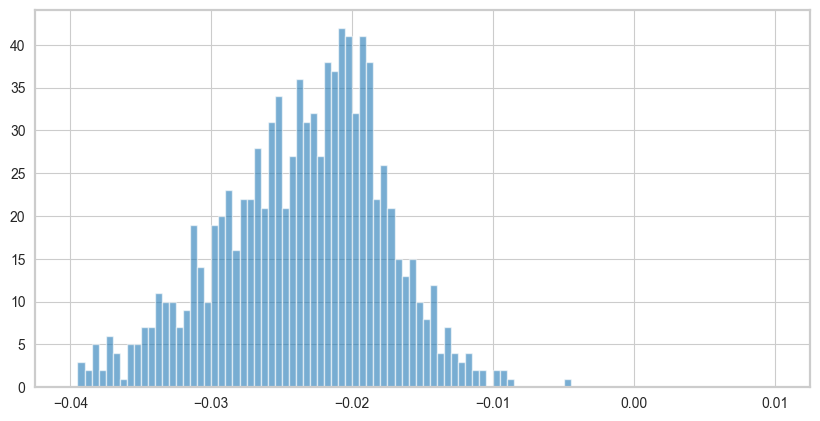

In [37]:
plt_kwargs = {'bins': 100,
              'range': (-0.04, 0.01)}
plt.hist(to_numpy(total_pnl), alpha=0.6, **plt_kwargs)
plt.show()

In [38]:
losses = learn(model, 200)

Loss: 0.02314: 100%|██████████| 200/200 [00:18<00:00, 11.04it/s]


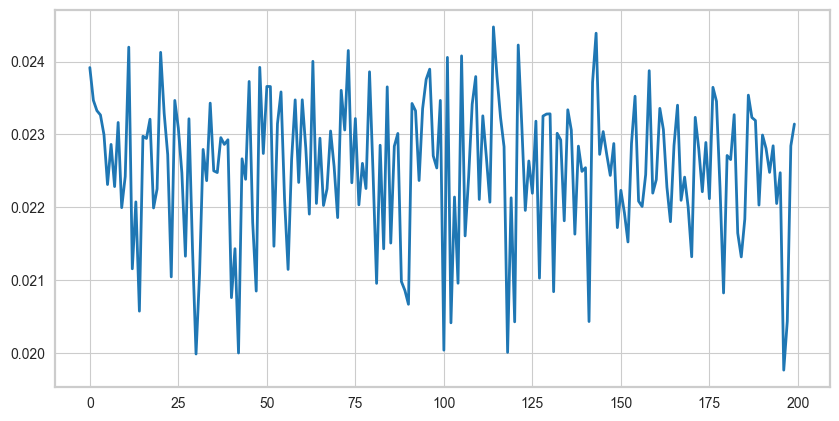

In [39]:
plt.plot(losses)

In [42]:
total_pnl_after = compute_pnl(model, 1000)

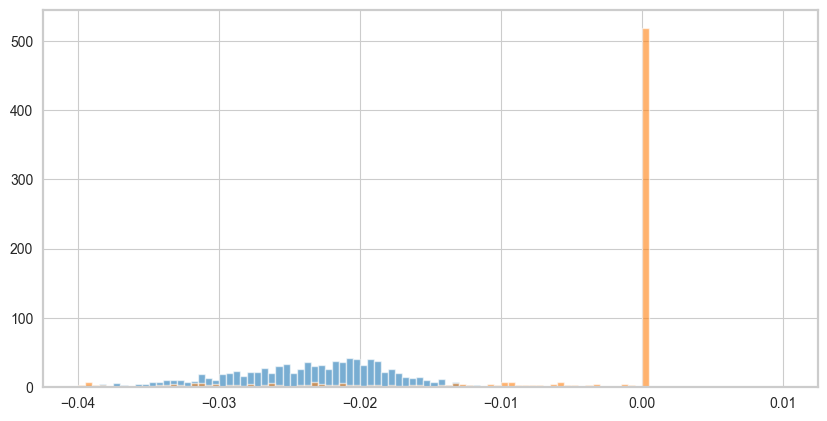

In [43]:
plt.hist(to_numpy(total_pnl), alpha=0.6, **plt_kwargs)
plt.hist(to_numpy(total_pnl_after), alpha=0.6, **plt_kwargs)
plt.show()

### TEST

In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib

from Utils.tensors import set_seed

sb.set_style('whitegrid')

FONTSIZE = 10
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

In [16]:
env_kwargs = { 'cost': 0.02,
               'dividend': 0.0,
                'drift':0.0,
                'freq': 1,
                'gen_name': "gbm",
                'init_price': 1.0,
                'n_assets': 1000,
                'maturity': 30,
                'payoff': "european",
                'payoff_coeff': 1.0,
                'period_unit': 365,
                'reward_fn': "mean var",
                'reward_fn_kwargs': {},
                'reward_mode': "pnl",
                'risk_free_interest': 0.0,
                'strike': 1.0,
                'volatility': 0.2}

from Env.env_torch import BSMarketTorch

set_seed()

raw = True
env_kwargs['reward_fn'] = 'raw' if raw else 'entropy'
env_kwargs['n_assets'] = 5000
env_kwargs['payoff_coeff'] = 0.0
env_kwargs['cost'] = 0.02
env = BSMarketTorch(**env_kwargs)

env 'BSMarket was created!


In [17]:
from ntb import NoTransactionBand

model_kwargs = {'features_in': 4,
                'net_arch': [32, 32, 32, 32],
                'activation_fn': nn.ReLU,
                'net_kwargs': None,
                'squash': True}

set_seed()
model = NoTransactionBand(**model_kwargs)
model

NoTransactionBand(
  (mlp): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=2, bias=True)
    (9): Tanh()
  )
)

In [18]:
from tqdm import tqdm
from Utils.prices_torch import pnl_entropic_loss

def compute_pnl(model, env):
    total_pnl = 0
    obs = env.reset()
    done, info = False, {}
    while not done:
        action = model(obs)
        obs, reward, done, info = env.step(action)
        total_pnl += reward

    return total_pnl

def fit(model: nn.Module, env, steps):
    optimizer = th.optim.Adam(model.parameters())
    losses = []
    progress = tqdm(range(steps))

    for step in progress:
        optimizer.zero_grad()
        pnl = compute_pnl(model, env)
        # loss = (-pnl.mean() if raw else -pnl)
        loss = (pnl_entropic_loss(pnl) if raw else -pnl)

        loss.backward()
        optimizer.step()

        progress.desc = f'Loss: {loss:.5f}'
        losses.append(loss.item())

    return losses

def get_reward(pnl, mode='mean'):
    if mode == 'mean':
        return pnl.mean() - 0.2*pnl.std()
    elif mode=='entropy':
        return -pnl_entropic_loss(pnl)

In [19]:
with th.no_grad():
    pnl_before = compute_pnl(model, env)

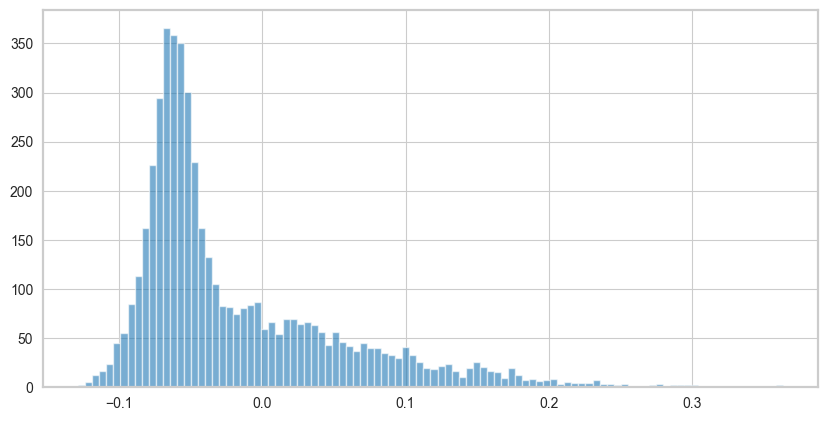

tensor(-0.0324)


In [20]:
from Utils.tensors import to_numpy

plt_kwargs = {'bins': 100,
              'alpha': 0.6}
plt.hist(to_numpy(pnl_before), **plt_kwargs)
plt.show()

print(get_reward(pnl_before))

In [21]:
losses = fit(model, env, 150)

Loss: 0.99369: 100%|██████████| 150/150 [00:36<00:00,  4.12it/s]


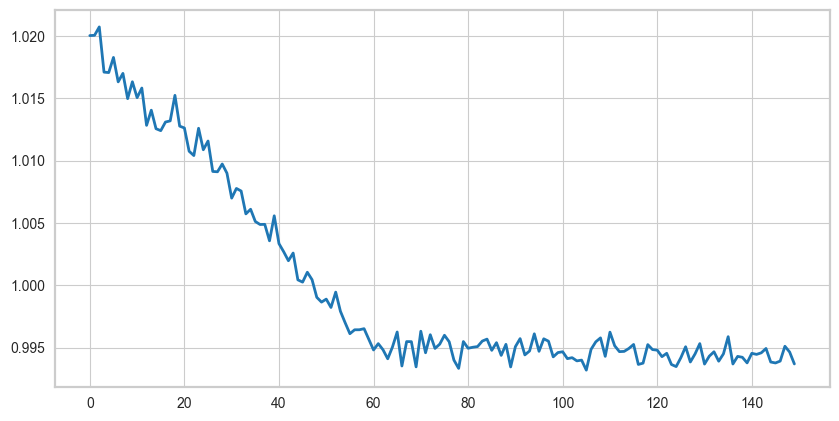

In [22]:
plt.plot(losses)
plt.show()

In [23]:
with th.no_grad():
    pnl_after = compute_pnl(model, env)

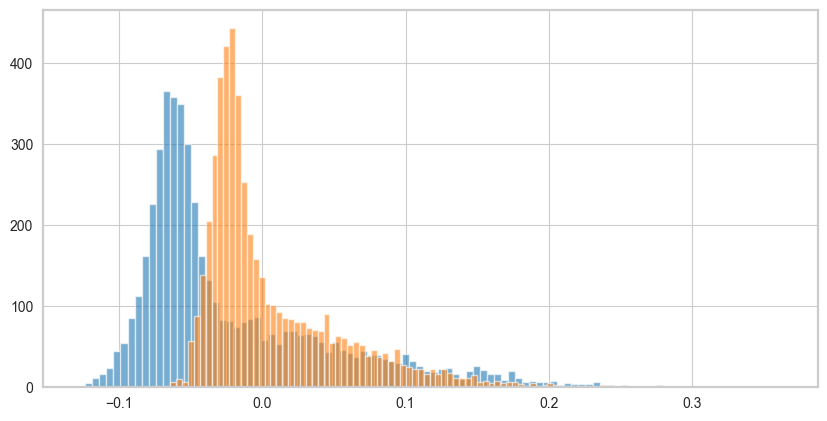

tensor(-0.0324)
tensor(-0.0032)


In [24]:
from Utils.tensors import to_numpy

plt.hist(to_numpy(pnl_before), **plt_kwargs)
plt.hist(to_numpy(pnl_after), **plt_kwargs)
plt.show()

print(get_reward(pnl_before))
print(get_reward(pnl_after))